In [ ]:
#Import all the necessary libraries

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [1]:
# Read the data
dfData = pd.read_csv('online_shoppers_intention.csv')


# Encode the classification labels to numbers
# Get classes and one hot encoded feature vectors
le = LabelEncoder()
le.fit(dfData['Revenue'])
allClasses = le.transform(dfData['Revenue'])
allFeatures = dfData.drop(['Revenue'], axis=1)

# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)

/home/nimisha/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):

    # Parse our feature columns that we don't use
    # Apply one hot encoding to the features
    # 1: We are using this Feature
    # 0: We are not using this Feature
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
    X_trainOhFeatures = pd.get_dummies(X_trainParsed)
    X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
    X_testOhFeatures = pd.get_dummies(X_testParsed)

    # Remove any columns that aren't in both the training and test sets
    #sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
    #removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
    #removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
    #X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
    #X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

    # Apply logistic regression on the data, and calculate accuracy
#     clf = LogisticRegression()
#     clf.fit(X_trainOhFeatures, y_train)
#     predictions = clf.predict(X_testOhFeatures)
#     accuracy = accuracy_score(y_test, predictions)
    clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    clf.fit(X_trainOhFeatures, y_train)
    predictions = clf.predict(X_testOhFeatures)
    accuracy = accuracy_score(y_test,predictions)


    # Return calculated accuracy as fitness
    return (accuracy,)

In [ ]:
# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dfData.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

#========

In [ ]:
def getHof():

    # Initialize variables to use eaSimple
    numPop = 100
    numGen = 5
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

In [ ]:
def getMetrics(hof):

    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]

    # Gather fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList


Test accuracy with all features: 	0.8459199189052204
Validation accuracy with all features: 	0.8333333333333334

gen	nevals	avg     	std       	min    	max     
0  	100   	0.847081	0.00381938	0.84592	0.865687
1  	47    	0.847172	0.00377144	0.84592	0.864166
2  	54    	0.84849 	0.00517687	0.84592	0.866194
3  	56    	0.852017	0.00810994	0.84592	0.886974
4  	62    	0.854384	0.00859468	0.84592	0.889002
5  	64    	0.857577	0.00777008	0.84592	0.869235

---Optimal Feature Subset(s)---

Percentile: 			1.0
Validation Accuracy: 		0.8803730738037308
Individual: 	[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Number Features In Subset: 	8
Feature Subset: ['Administrative', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'Month', 'OperatingSystems', 'TrafficType', 'Weekend']


/home/nimisha/.local/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


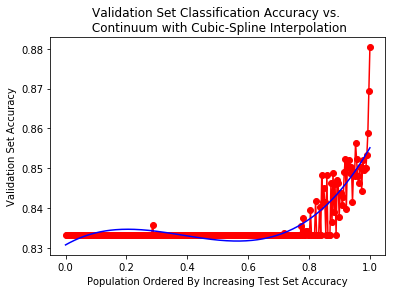

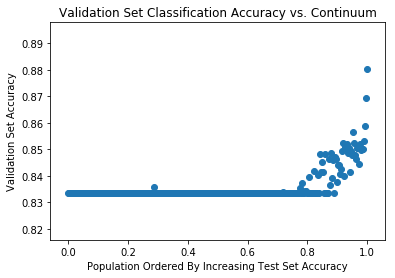

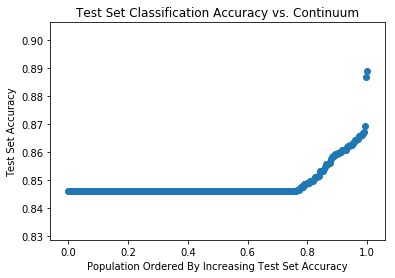

In [2]:
if __name__ == '__main__':

    '''
    First, we will apply logistic regression using all the features to acquire a baseline accuracy.
    '''
    individual = [1 for i in range(len(allFeatures.columns))]
    testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
    validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
    print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
    print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')

    '''
    Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
    '''
    hof = getHof()
    testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

    # Get a list of subsets that performed best on validation data
    maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
    maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
    maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

    print('\n---Optimal Feature Subset(s)---\n')
    for index in range(len(maxValAccSubsetIndicies)):
        print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
        print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
        print('Individual: \t' + str(maxValIndividuals[index]))
        print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
        print('Feature Subset: ' + str(maxValSubsets[index]))

    '''
    Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature subsets to the 
    best feature subsets found by the genetic algorithm.
    '''
    # Calculate best fit line for validation classification accuracy (non-linear)
    tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
    ynew = interpolate.splev(percentileList, tck)

    e = plt.figure(1)
    plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
    plt.plot(percentileList, ynew, color='b')
    plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    e.show()

    f = plt.figure(2)
    plt.scatter(percentileList, validationAccuracyList)
    plt.title('Validation Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Validation Set Accuracy')
    f.show()

    g = plt.figure(3)
    plt.scatter(percentileList, testAccuracyList)
    plt.title('Test Set Classification Accuracy vs. Continuum')
    plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
    plt.ylabel('Test Set Accuracy')
    g.show()

In [3]:


#sudo apt install python3-tk